In [1]:
import numpy
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%run fdtools.py
hbar=1.05e-34
m=9.10e-31

# One Dimensional Time Independent Schrodinger Equation (TISE) - A Naive Approach

The most basic form of the schrodinger equations is 

$$ \frac{-\hbar^2}{2m}\frac{d^2\psi(x)}{dx^2} + V(x)\psi(x) = E\psi(x) \\ $$

$$ \frac{\hbar^2}{2m}\frac{d^2\psi(x)}{dx^2} + (E - V(x))\psi(x) = 0 \\ $$

The differences in solutions will arise from two major sources. First, the boundary conditions provide invaluable information about how initialization of the problem and the limits. Second, the value of the potential function, $V(x)$, provides information about how the particle will behave in time and space. 

For the first problem, we'll let the potential be defined as the following $ \\ $

![caption](square-well.png) 
WLOG we can shift the potential well to 0 to a.


When $V(x) = 0$ the problem becomes a simple eignen function problem where $H\psi(x) = E\psi(x)$. So, the eigenfunctions of H are the vectors approximating the wave function. H is defined as $$ H = \frac{-\hbar^2}{2m} \frac{\partial^2}{\partial x^2} $$

Now all we have to do is choose a stencil for the second derivative approximation. Here we will use the stencil $$ S = (2h)^{-2} * \begin{bmatrix} 1 && -2 && 1 \end{bmatrix} $$

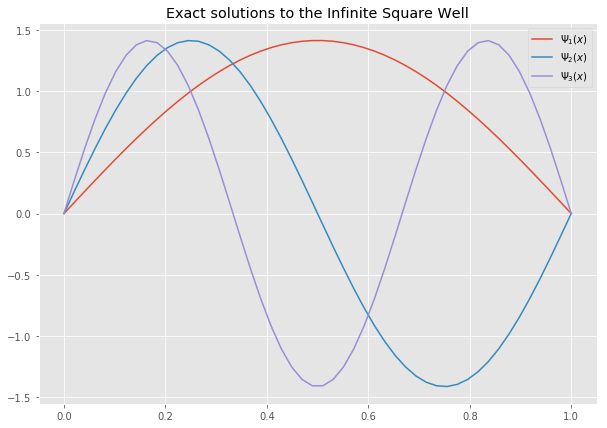

In [107]:
def TISE_InfSqrWell(x,l,n):
    #solution to the infinite well from 0 to l
    return numpy.sqrt(2.0/l) * numpy.sin((n*numpy.pi*x)/l)
a = 1.0
x = numpy.linspace(0,a)
plt.figure(figsize=(10,7))
plt.title('Exact solutions to the Infinite Square Well')
for i in range(1,4):
    u = TISE_InfSqrWell(x, a, i)
    plt.plot(x,u, label="$\Psi_{}(x)$".format(i))
plt.legend(bbox_to_anchor=(1,1));

In [109]:
def TISE_laplacian(a,N):
    x = numpy.linspace(0,a,N)
    h = x[1]-x[0]
    ddx = 1./((2*h)**2)*(numpy.diag(numpy.ones(N-1),-1) -2* numpy.diag(numpy.ones(N),0) + numpy.diag(numpy.ones(N-1),1))
    H = -(hbar*hbar)/(2.0*m)*ddx
    E,psiT = numpy.linalg.eigh(H) 
    psi = psiT.T/numpy.sqrt(h)
    return x,E,psi

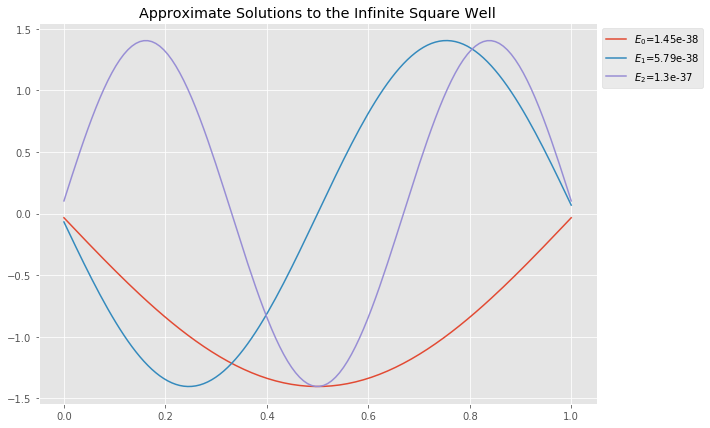

In [125]:
a = 1
N = 128
x, E, psi = TISE_laplacian(a,N)
plt.figure(figsize=(10,7))
plt.title("Approximate Solutions to the Infinite Square Well")
for i in range(3):
    plt.plot(x,psi[i], label="$E_{}$={:.3}".format(i,E[i]))
plt.legend(bbox_to_anchor=(1,1))
plt.show()

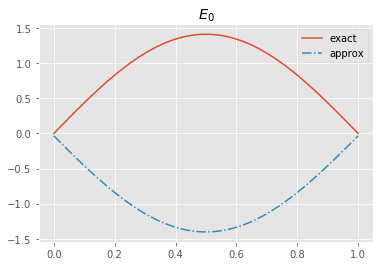

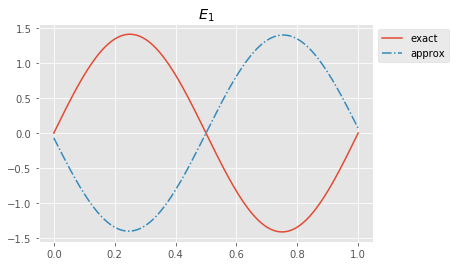

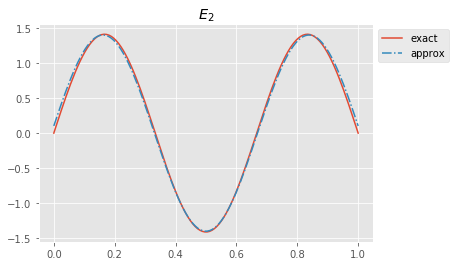

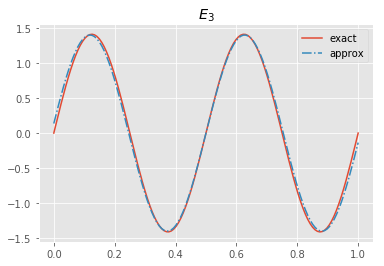

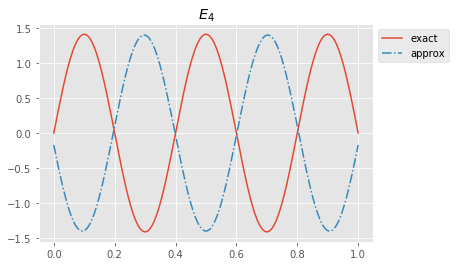

In [126]:
for i in range(5):
    plt.figure()
    plt.title("$E_{}$".format(i))
    u = TISE_InfSqrWell(x, a, i+1)
    plt.plot(x,u, label='exact')
    plt.plot(x,psi[i], '-.', label='approx')
    plt.legend(bbox_to_anchor = (1,1))

Some of these wave functions match fairly well, but others seem to have a sign problem in regards to $\psi(x)$. Let's look at the accuracy of $\psi(x)^2$ and then we'll try to solve TISE with another method. 

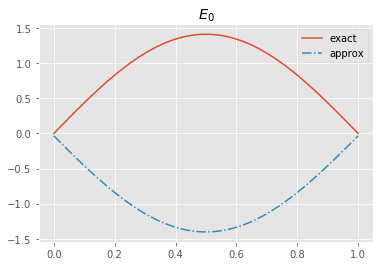

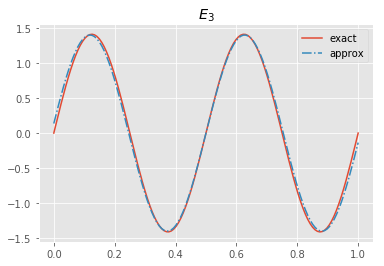

In [127]:
for i in [0, 3]:
    plt.figure()
    plt.title("$E_{}$".format(i))
    u = TISE_InfSqrWell(x, a, i+1)
    plt.plot(x,u, label='exact')
    plt.plot(x,psi[i], '-.', label='approx')
    plt.legend(bbox_to_anchor = (1,1))

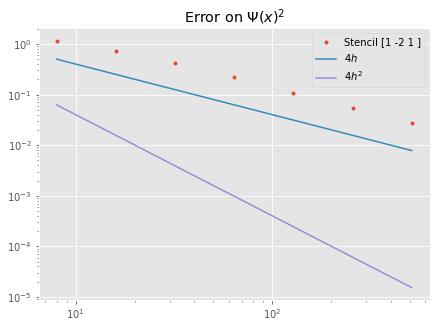

In [128]:
hs = 2**numpy.arange(3,10)
#we'll use n = 3
error = []
a = 1.0
n = 3
plt.figure(figsize=(7,5))
plt.title('Error on $\Psi(x)^2$')
for N in hs:
    x, E, psi = TISE_laplacian(1, N)
    u = TISE_InfSqrWell(x, a, n)
    error.append(numpy.linalg.norm(u**2 - (psi[n-1])**2, ord=numpy.inf))
plt.loglog(hs, error, '.', label='Stencil [1 -2 1 ]')
plt.loglog(hs, 4*(1/hs), label='$4h$')
plt.loglog(hs, 4*(1/hs)**2, label='$4h^2$')
plt.legend(bbox_to_anchor=(1,1));

This method gives us a first order accuracy for a simple model, but we can do much better and will test it out on more complex models. Let's try a RK-4 or a Bogacki-Shampine method.

# TISE - Runge-Kutta Methods

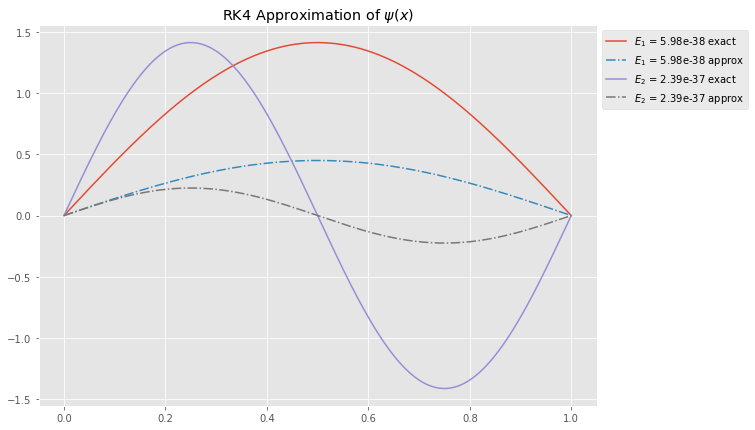

In [132]:
class TISE:
    def __init__(self,E):
        self.E = E
    def f(self,t,u):
        return numpy.array([u[1], u[0]*(-2*m*self.E)/(hbar**2)])

def E(n, a):
    return (n*n*numpy.pi*numpy.pi*hbar*hbar)/(2*m*a)

def TISE_rkexplicit(f, u0, butcher=None, tfinal=1, h=.1):
    if butcher is None:
        A, b = rk_butcher_4()
    else:
        A, b = butcher
    c = numpy.sum(A, axis=1)
    s = len(c)
    u = u0.copy()
    t = 0
    hist = [(t,u0)]
    while t < tfinal:
        if tfinal - t < 1.01*h:
            h = tfinal - t
            tnext = tfinal
        else:
            tnext = t + h
        h = min(h, tfinal - t)
        fY = numpy.zeros((len(u0), s))
        for i in range(s):
            Yi = u.copy()
            for j in range(i):
                Yi += h * A[i,j] * fY[:,j]
            fY[:,i] = f(t + h*c[i], Yi)
        u += h * fY.dot(b)
        t = tnext
        hist.append((t, u.copy()))
    return hist

a = 1.0
N = 256
plt.figure(figsize=(10,7))
plt.title("RK4 Approximation of $\psi(x)$")
for i in range(1,3):
    Ei = E(i,a)
    h = (1/N)
    waves = TISE(Ei)
    u0 = numpy.array([0, numpy.sqrt(2.0/a)])
    hist = TISE_rkexplicit(waves.f, u0, tfinal=a, h = h)
    x = numpy.array([x for x,u in hist])
    psi = numpy.array([u[0] for x,u in hist])
    u = TISE_InfSqrWell(x, a, i)
    plt.plot(x, u, label="$E_{}$ = {:.3} exact".format(i,Ei))
    plt.plot(x, psi, '-.',label="$E_{}$ = {:.3} approx".format(i,Ei))
plt.legend(bbox_to_anchor=(1,1));